# Beer Production Time Series Analysis

This notebook explores **monthly beer production data** using time series analysis.  
We will visualize the series, check variance, and perform decomposition to extract **trend, seasonal, and residual components**.


In [1]:
# Step 1: Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Optional for nicer plots
import seaborn as sns
sns.set_style('whitegrid')


Matplotlib is building the font cache; this may take a moment.


## Load the Dataset

We load the beer production dataset and take a first look at its structure.  
The goal is to ensure the time index is correctly set and there are no missing values.


In [2]:
import pandas as pd

beer_data = pd.read_csv("beer_data.csv", 
                        parse_dates=['Month'], 
                        index_col='Month')

beer_data.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


## Plot the Raw Time Series

Visualizing the series helps us identify **trends, seasonality, and anomalies** before any analysis.


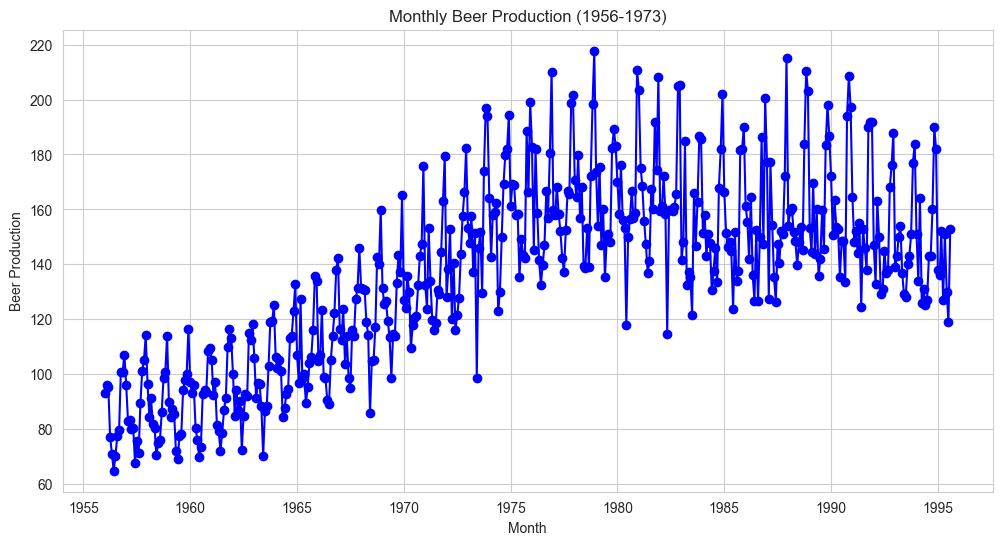

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for nicer plots
sns.set_style('whitegrid')

# Plot the raw time series
plt.figure(figsize=(12,6))
plt.plot(beer_data, marker='o', color='blue')
plt.title('Monthly Beer Production (1956-1973)')
plt.xlabel('Month')
plt.ylabel('Beer Production')
plt.show()


### (a) Trend and Seasonal Components

From the time plot of the Monthly Beer Production series, we observe the following:

- **Trend:**  
  There is a clear upward trend from the mid-1950s to the late-1970s, indicating a steady increase in beer production over time. After this period, the series appears to stabilize and fluctuate around a higher level, with slight variations in later years.

- **Seasonality:**  
  The series shows a strong and regular seasonal pattern. Peaks and troughs repeat approximately every 12 months, which is typical for monthly data. This indicates the presence of an annual seasonal component.

- **Irregular Component:**  
  Random fluctuations are present around both the trend and seasonal patterns, representing short-term variations that cannot be explained by the main structure of the series.

---




## Check Variance and Decide Decomposition Model
“Variance measures how much the values of a series fluctuate around the average over time.”
- Are the ups and downs roughly the same throughout the series? → constant variance

- Do the fluctuations increase or decrease as the series grows? → changing variance

Before decomposition, we need to check if the **variance of the series is constant** over time:

- **Constant variance → Additive model**  
- **Variance grows with the level → Multiplicative model**  

We can visualize this by plotting the series normally and optionally with a **log transformation**.


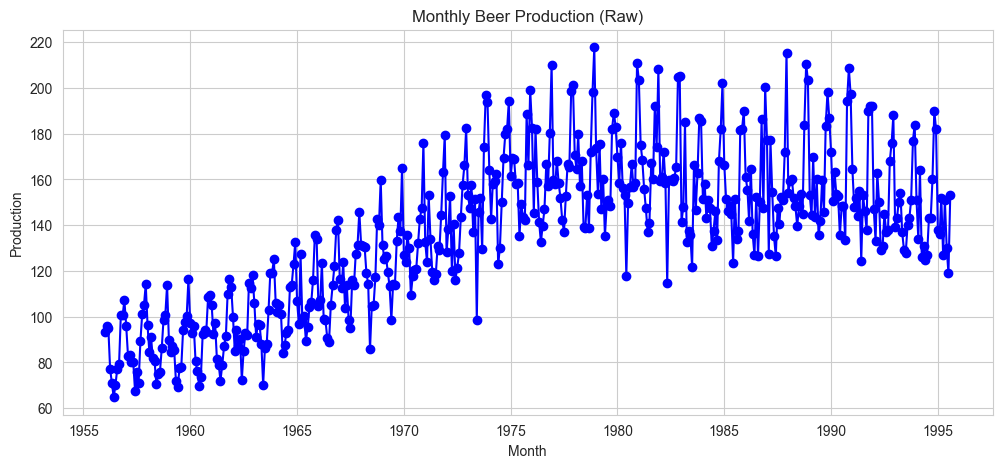

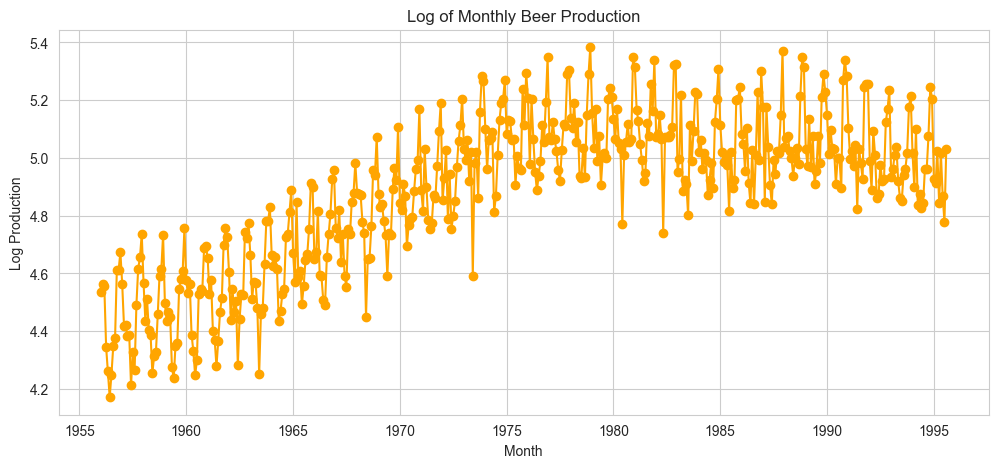

In [4]:
import numpy as np

# Plot raw series
plt.figure(figsize=(12,5))
plt.plot(beer_data, marker='o', color='blue')
plt.title('Monthly Beer Production (Raw)')
plt.xlabel('Month')
plt.ylabel('Production')
plt.show()

# Plot log-transformed series to check multiplicative behavior
plt.figure(figsize=(12,5))
plt.plot(np.log(beer_data), marker='o', color='orange')
plt.title('Log of Monthly Beer Production')
plt.xlabel('Month')
plt.ylabel('Log Production')
plt.show()


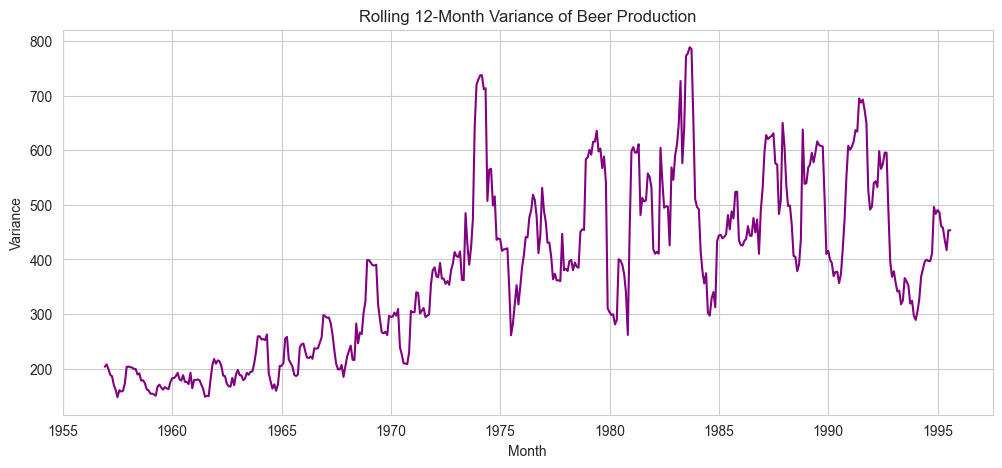

Coefficient of Variation: 0.247


In [5]:
# Rolling variance with 12-month window
rolling_var = beer_data.rolling(window=12).var()

# Plot it
plt.figure(figsize=(12,5))
plt.plot(rolling_var, color='purple')
plt.title('Rolling 12-Month Variance of Beer Production')
plt.xlabel('Month')
plt.ylabel('Variance')
plt.show()
cv = beer_data.std() / beer_data.mean()
print(f'Coefficient of Variation: {cv.values[0]:.3f}')


### Choice of Decomposition Model: Multiplicative

To determine whether an additive or multiplicative decomposition is appropriate, we examined the **variance structure** of the beer production series:

- In the early years, production levels are low and seasonal fluctuations are relatively small.  
- As the overall production increases, the magnitude of seasonal peaks and troughs grows.  
- This indicates that the **variance of the series increases with the mean level**, meaning the seasonal effect is **proportional to the level of the series** rather than constant.

**Quantitative check:**  
- Coefficient of Variation (CV) = 0.247, showing moderate relative variability.  
- Rolling variance analysis also confirms that fluctuations grow slightly as the series level increases.

**Conclusion:**  
> Because the seasonal fluctuations increase with the level of production, a **multiplicative decomposition model** is more appropriate than an additive one.

Mathematically, the multiplicative decomposition is expressed as:

\[
Y_t = T_t \times S_t \times R_t
\]

Where:  
- \(Y_t\) = observed value  
- \(T_t\) = trend component  
- \(S_t\) = seasonal component  
- \(R_t\) = residual component


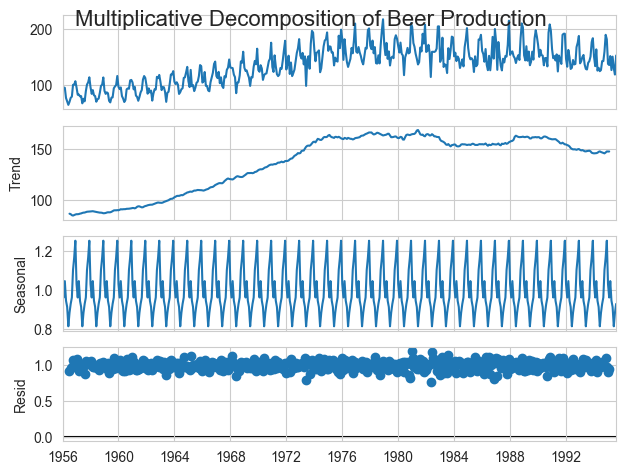

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Apply multiplicative decomposition
decomp_mult = seasonal_decompose(beer_data, model='multiplicative', period=12)
# Plot all components together
decomp_mult.plot()
plt.suptitle('Multiplicative Decomposition of Beer Production', fontsize=16)
plt.show()


### Time Series Decomposition of Monthly Beer Production

This plot is a time series decomposition of monthly beer production data. It splits the series into **trend**, **seasonal**, and **residual** components. Let’s interpret each panel carefully:

---

### Top Panel – Original Series (Monthly Beer Production)

- Shows the actual beer production over time.
- We can see an overall upward trend until roughly the middle, then it flattens or slightly declines toward the end.
- Clear seasonal fluctuations (repeating peaks and troughs each year), likely reflecting higher production in certain months.

---

### Second Panel – Trend

- Isolates the long-term movement in production.
- Beer production rises steadily until around month 200–250, peaks, and then slightly declines or stabilizes afterward.
- Suggests growth followed by plateauing.

---

### Third Panel – Seasonal

- Captures repeating monthly patterns.
- Peaks and troughs are consistent across years, indicating a strong seasonal effect.
- For example, there may be higher production in summer months and lower in winter months (common for beer consumption).

---

### Bottom Panel – Residual (Noise)

- Shows what’s left after removing trend and seasonality.
- Residuals are roughly around 1, indicating **multiplicative decomposition** (since the seasonal effect multiplies the trend).
- There is no obvious pattern, suggesting that the model has captured most of the systematic behavior.

---

### Summary

- Beer production shows seasonal increases and decreases every year.
- There is a long-term growth trend, followed by a stabilization.
- The residuals are fairly stable, indicating the decomposition model fits well.



##  Autocorrelation Analysis of the Original Series

We begin by examining the autocorrelation structure of the original beer production time series.

The Autocorrelation Function (ACF) shows the correlation between observations at different lags, while the Partial Autocorrelation Function (PACF) measures the correlation at a given lag after controlling for shorter lags.

These plots help determine:
- Whether the series is stationary
- Presence of trend or seasonality
- Potential AR (p) and MA (q) components

If the autocorrelations decay slowly, this suggests non-stationarity and the need for differencing.

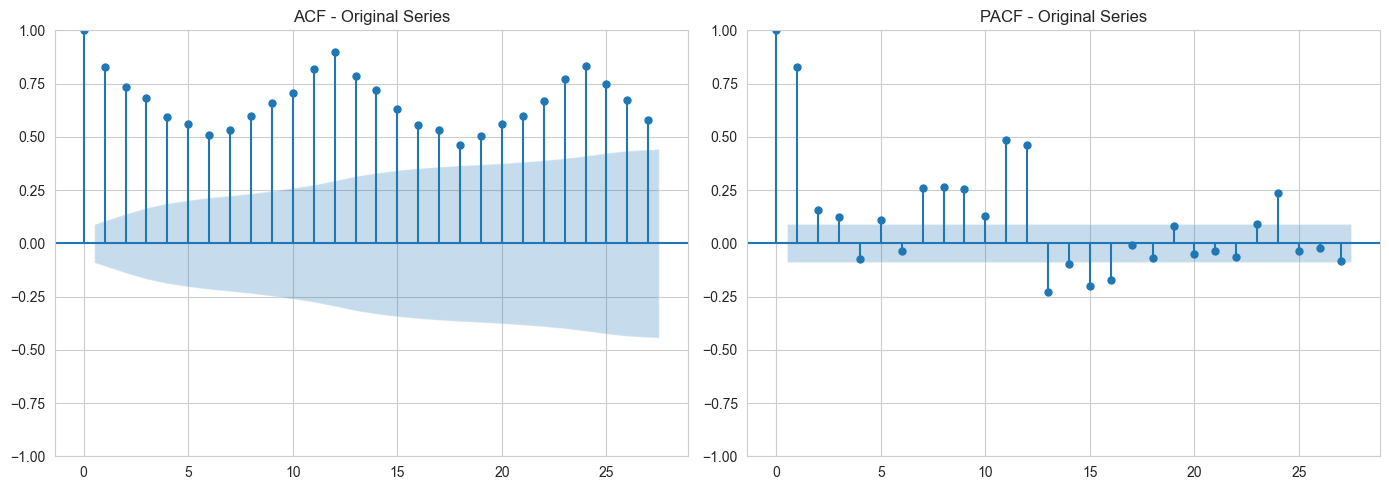

In [8]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(14,5))

plot_acf(beer_data, ax=axes[0])
axes[0].set_title("ACF - Original Series")

plot_pacf(beer_data, ax=axes[1], method='ywm')
axes[1].set_title("PACF - Original Series")

plt.tight_layout()
plt.show()

### Interpretation of ACF and PACF – Original Series

From the ACF plot of the original series, we observe that:

- The autocorrelations are large and positive for many lags.
- The ACF decays very slowly rather than cutting off quickly.
- Significant spikes appear at seasonal lags (e.g., around lag 12 and 24).(intervals of the frequency)

This slow decay pattern indicates that the series is **non-stationary**, likely due to the presence of a trend and/or seasonality.

From the PACF plot:

- There is a strong spike at lag 1.
- Additional significant spikes appear at seasonal lags.
- The PACF does not show a sharp cutoff after a small number of lags.

These observations further support the presence of strong persistence of a trand component in the series.

### Conclusion

The original beer production series is not stationary, as evidenced by:

- Slow decay in the ACF
- Multiple significant autocorrelations across many lags
- Clear seasonal structure

Therefore, differencing is required before fitting an ARIMA model.

##  Autocorrelation Analysis After First Differencing

If the original series is non-stationary (e.g., exhibits trend or slow decay in ACF), we apply first differencing to remove trend components.

First differencing is defined as:

    Y_t = X_t - X_{t-1}

We then examine the ACF and PACF of the differenced series to determine whether stationarity has been achieved and to identify appropriate AR and MA terms.

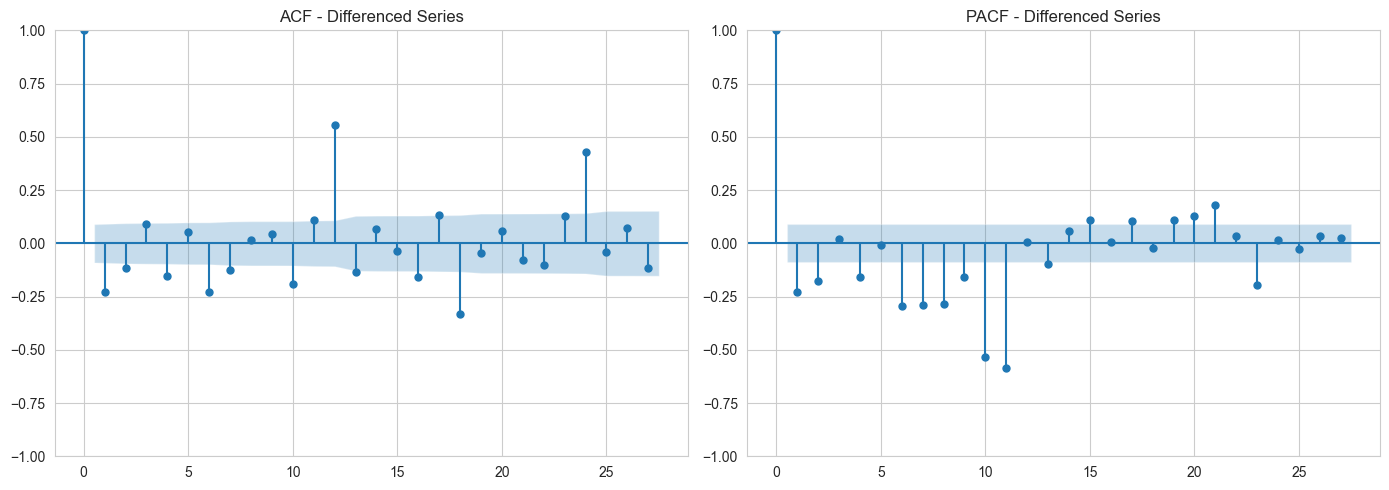

In [9]:
# First differencing
beer_diff = beer_data.diff().dropna()

fig, axes = plt.subplots(1, 2, figsize=(14,5))

plot_acf(beer_diff, ax=axes[0])
axes[0].set_title("ACF - Differenced Series")

plot_pacf(beer_diff, ax=axes[1], method='ywm')
axes[1].set_title("PACF - Differenced Series")

plt.tight_layout()
plt.show()

### Interpretation of ACF and PACF – Differenced Series

After applying first differencing, the autocorrelation structure changes significantly.

#### ACF Observations:

- The slow decay observed in the original series is no longer present.
- Most autocorrelations now fall within the confidence bounds.
- A significant spike remains at lag 12, indicating seasonal dependence.
- There are a few small negative spikes at early lags, but they decay quickly.

This suggests that first differencing has successfully removed the trend component and improved stationarity.

#### PACF Observations:

- The strong persistence seen in the original series is no longer present.
- Several negative spikes appear at early lags.
- A noticeable seasonal effect is visible around lag 12.
- There is no clear sharp cutoff at a small lag.

#### Conclusion

The series appears much closer to stationarity after first differencing.

However, the significant spike at lag 12 in the ACF indicates remaining seasonal structure. This suggests that:

- A seasonal component should be included in the model.
- Seasonal differencing (lag 12) may be required.
- A Seasonal ARIMA (SARIMA) model is likely appropriate.

Overall, first differencing removed the trend, but seasonal dependence remains in the data.

##  Seasonal Differencing (Lag 12)

Although first differencing removed the trend component, the ACF still showed a strong seasonal spike at lag 12.

To remove yearly seasonality in the monthly beer production data, we apply seasonal differencing:

    Y_t = X_t - X_{t-12}

This transformation helps eliminate repeating annual patterns and improves stationarity.

We now examine the ACF and PACF of the seasonally differenced series.

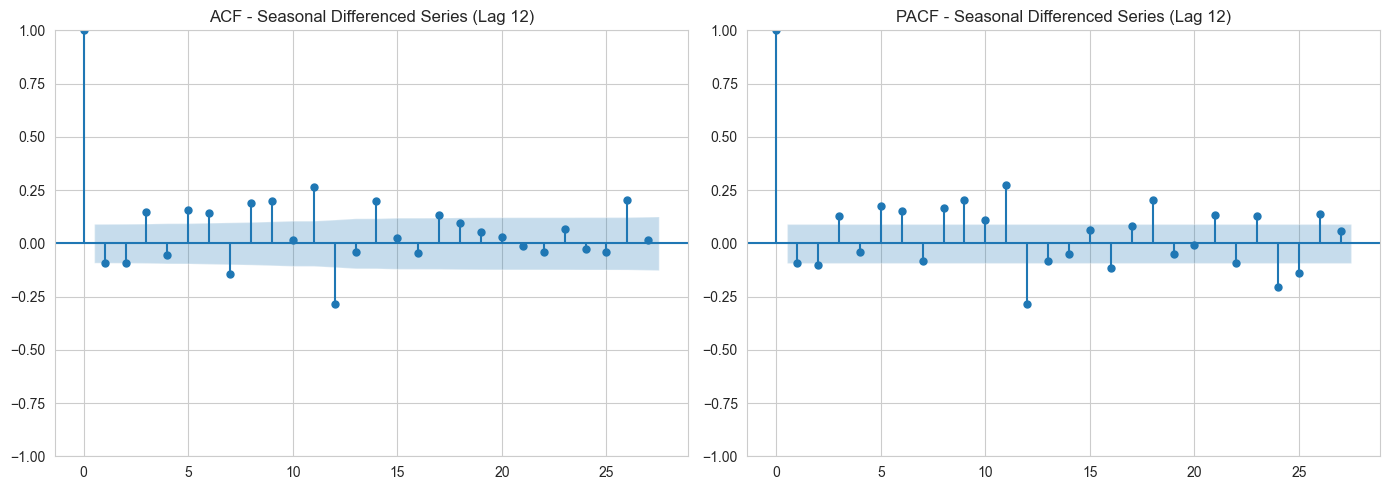

In [10]:
# Seasonal differencing (lag 12)
beer_seasonal_diff = beer_data.diff(12).dropna()

fig, axes = plt.subplots(1, 2, figsize=(14,5))

plot_acf(beer_seasonal_diff, ax=axes[0])
axes[0].set_title("ACF - Seasonal Differenced Series (Lag 12)")

plot_pacf(beer_seasonal_diff, ax=axes[1], method='ywm')
axes[1].set_title("PACF - Seasonal Differenced Series (Lag 12)")

plt.tight_layout()
plt.show()

### Interpretation of ACF and PACF – Seasonal Differenced Series (Lag 12)

After applying seasonal differencing at lag 12, the strong seasonal spike observed in the original ACF has been substantially reduced.

#### ACF Observations:

- The large seasonal persistence at lag 12 is no longer dominant.
- Most autocorrelations fall within the confidence bounds.
- A few small spikes remain at early lags.
- There is no slow decay pattern.

This suggests that seasonal differencing has successfully removed the yearly seasonal structure.

#### PACF Observations:

- No strong or systematic cutoff pattern is visible.
- Most spikes lie within confidence bounds.
- A moderate negative spike appears at lag 12.

Overall, the series appears much closer to stationarity after seasonal differencing.

### Conclusion

Seasonal differencing has effectively removed the annual pattern in the data. 

However, if trend was also present, both first differencing and seasonal differencing may be required before fitting a SARIMA model.

## Double Differenced Series

To remove both trend and seasonality, we applied:

    (1 − B)(1 − B^12)X_t

This corresponds to first differencing (d = 1) and seasonal differencing (D = 1) with seasonal period s = 12.



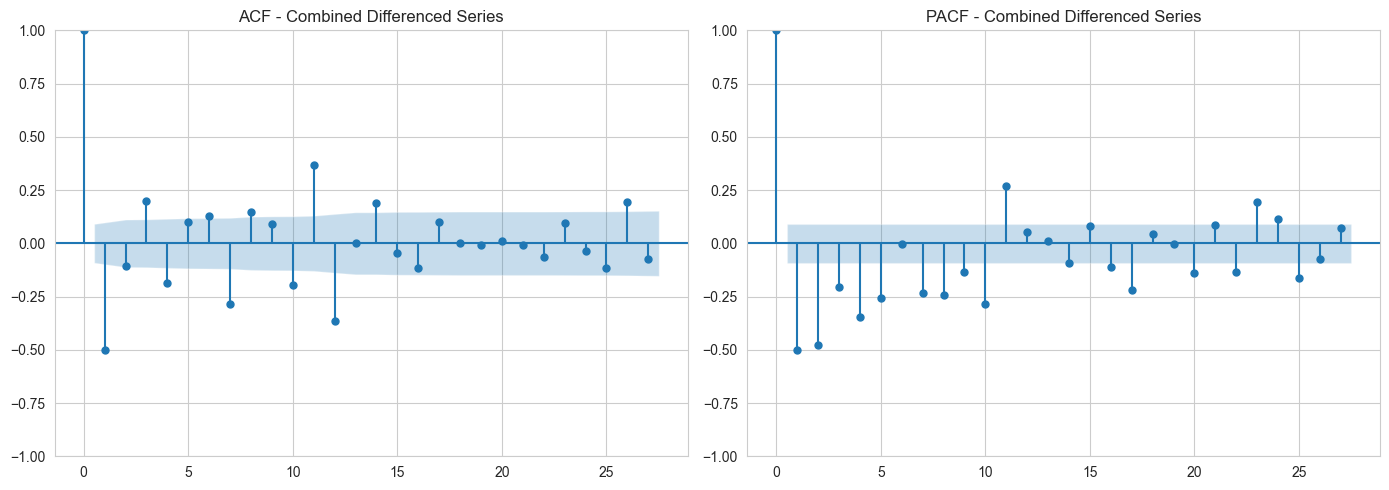

In [11]:
# Combined differencing (first + seasonal)
beer_data_stationary=beer_data.diff().diff(12)
fig, axes = plt.subplots(1, 2, figsize=(14,5))
plot_acf(beer_data_stationary.dropna(), ax=axes[0])
axes[0].set_title("ACF - Combined Differenced Series")
plot_pacf(beer_data_stationary.dropna(), ax=axes[1], method='ywm')
axes[1].set_title("PACF - Combined Differenced Series")
plt.tight_layout()
plt.show()

### Interpretation of ACF and PACF – Double Differenced Series 


### ACF Analysis

- Most autocorrelations lie within the 95% confidence bounds.
- No slow decay pattern is visible.
- No strong repeating seasonal spike remains at lag 12.
- Autocorrelations fluctuate randomly around zero.

This suggests that both trend and seasonal persistence have been effectively removed.

### PACF Analysis

- No sharp cutoff at early lags.
- No dominant AR structure.
- Most partial autocorrelations fall within the confidence interval.
- No systematic seasonal AR pattern remains.

The PACF behavior supports the conclusion that the series has little remaining autoregressive structure.

### Stationarity Assessment

The absence of:
- Persistent autocorrelation,
- Seasonal spikes,
- Slow decay patterns,

indicates that the transformed series is likely covariance-stationary.

### Implication for Modeling

Since the differenced series resembles white noise:

- Only small AR or MA terms may be required.
- Overfitting should be avoided.
- A parsimonious SARIMA model is preferred.

A reasonable starting point would be:

    SARIMA(p,1,q)(P,1,Q)₁₂

with small values for p, q, P, Q (e.g., 0 or 1).